# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

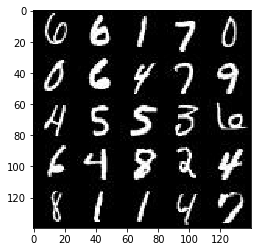

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

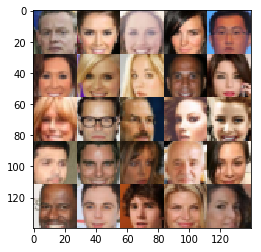

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 128
    alpha = 0.1
    
    
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        #h1 = tf.layers.dense( tf.contrib.layers.flatten(images), n_units, activation=None)
        # Leaky ReLU
        #h1 = tf.maximum(alpha * h1, h1)
        
        #logits = tf.layers.dense(h1, 1, activation=None)
        #out = tf.sigmoid(logits)
        
        x = tf.layers.conv2d(x, 64, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.6)
        
        
        x2 = tf.layers.conv2d(x, 128, 4, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, 0.6)
        
        x3 = tf.layers.conv2d(x2, 256, 4, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x2, 0.6)
        
        
        x_out = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x_out, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha= 0.1
    n_units= 128
    with tf.variable_scope("generator", reuse = reuse):
      
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x2 = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x_out = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding="same")
        
        logits = x_out
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    count=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                    
                count =count+1
                # Get images, reshape and rescale to pass to D
              
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
             
                # Run optimizers
                
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr:learning_rate})
                    
                if count % 50 == 0:
                    train_loss_d = d_loss.eval({z_inputs:batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs:batch_z})
                    print("Epoch {}/{} Steps {}...".format(epoch_i+1, epoch_count, count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if count % 100 == 0:
                    show_generator_output(sess, 25, z_inputs, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Steps 50... Discriminator Loss: 1.9855... Generator Loss: 0.4161
Epoch 1/2 Steps 100... Discriminator Loss: 1.7229... Generator Loss: 0.4760


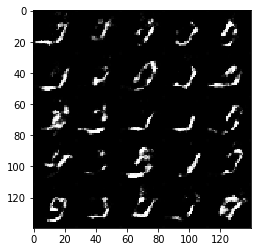

Epoch 1/2 Steps 150... Discriminator Loss: 1.6761... Generator Loss: 0.7922
Epoch 1/2 Steps 200... Discriminator Loss: 1.5525... Generator Loss: 0.6431


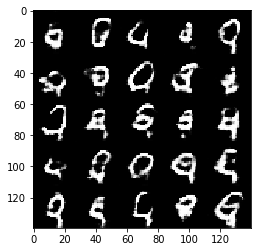

Epoch 1/2 Steps 250... Discriminator Loss: 1.7262... Generator Loss: 0.3742
Epoch 1/2 Steps 300... Discriminator Loss: 1.5806... Generator Loss: 0.5442


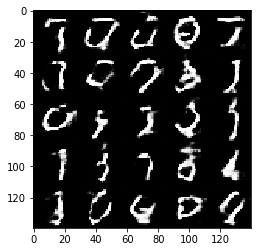

Epoch 1/2 Steps 350... Discriminator Loss: 1.5886... Generator Loss: 0.9918
Epoch 1/2 Steps 400... Discriminator Loss: 1.6092... Generator Loss: 0.4748


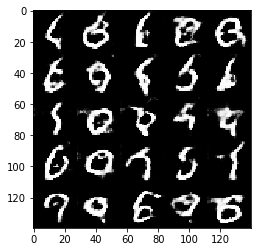

Epoch 1/2 Steps 450... Discriminator Loss: 1.6187... Generator Loss: 0.5409
Epoch 1/2 Steps 500... Discriminator Loss: 1.5541... Generator Loss: 0.6499


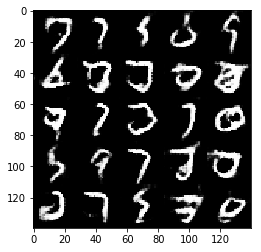

Epoch 1/2 Steps 550... Discriminator Loss: 1.4633... Generator Loss: 0.8654
Epoch 1/2 Steps 600... Discriminator Loss: 1.5112... Generator Loss: 0.8413


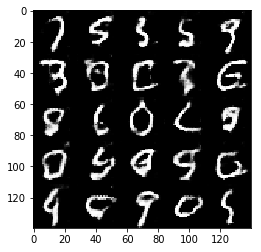

Epoch 1/2 Steps 650... Discriminator Loss: 1.5521... Generator Loss: 0.8271
Epoch 1/2 Steps 700... Discriminator Loss: 1.5004... Generator Loss: 0.7328


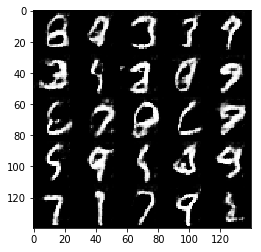

Epoch 1/2 Steps 750... Discriminator Loss: 1.4764... Generator Loss: 0.8970
Epoch 1/2 Steps 800... Discriminator Loss: 1.4635... Generator Loss: 0.5590


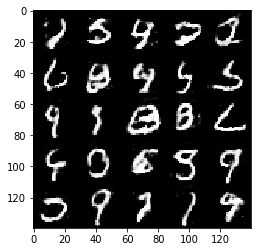

Epoch 1/2 Steps 850... Discriminator Loss: 1.5126... Generator Loss: 1.0460
Epoch 1/2 Steps 900... Discriminator Loss: 1.4514... Generator Loss: 0.5950


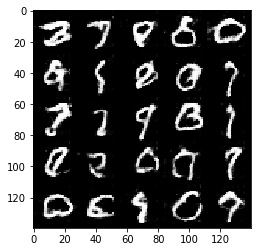

Epoch 1/2 Steps 950... Discriminator Loss: 1.4429... Generator Loss: 0.7922
Epoch 1/2 Steps 1000... Discriminator Loss: 1.5871... Generator Loss: 0.4298


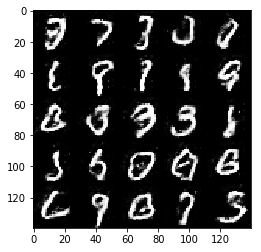

Epoch 1/2 Steps 1050... Discriminator Loss: 1.4483... Generator Loss: 0.7379
Epoch 1/2 Steps 1100... Discriminator Loss: 1.5832... Generator Loss: 0.4318


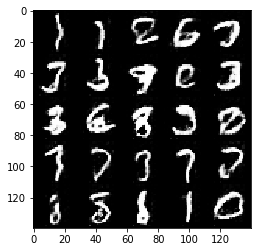

Epoch 1/2 Steps 1150... Discriminator Loss: 1.5178... Generator Loss: 0.9489
Epoch 1/2 Steps 1200... Discriminator Loss: 1.4617... Generator Loss: 0.6696


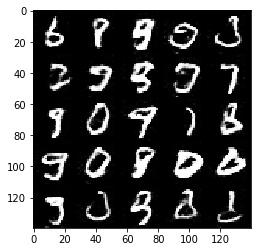

Epoch 1/2 Steps 1250... Discriminator Loss: 1.4353... Generator Loss: 0.6949
Epoch 1/2 Steps 1300... Discriminator Loss: 1.5324... Generator Loss: 0.7963


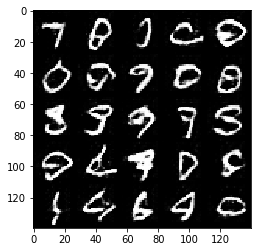

Epoch 1/2 Steps 1350... Discriminator Loss: 1.5028... Generator Loss: 0.6783
Epoch 1/2 Steps 1400... Discriminator Loss: 1.5456... Generator Loss: 0.5093


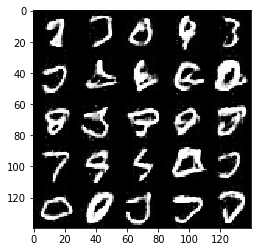

Epoch 1/2 Steps 1450... Discriminator Loss: 1.4935... Generator Loss: 0.8803
Epoch 1/2 Steps 1500... Discriminator Loss: 1.4847... Generator Loss: 0.6292


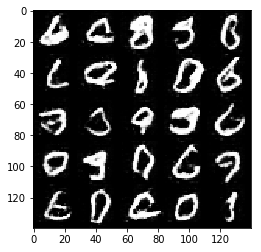

Epoch 1/2 Steps 1550... Discriminator Loss: 1.4644... Generator Loss: 0.7828
Epoch 1/2 Steps 1600... Discriminator Loss: 1.5214... Generator Loss: 0.4998


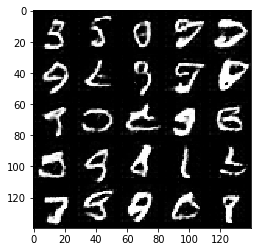

Epoch 1/2 Steps 1650... Discriminator Loss: 1.3867... Generator Loss: 0.8867
Epoch 1/2 Steps 1700... Discriminator Loss: 1.4263... Generator Loss: 0.7260


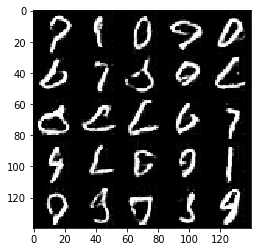

Epoch 1/2 Steps 1750... Discriminator Loss: 1.5367... Generator Loss: 0.6347
Epoch 1/2 Steps 1800... Discriminator Loss: 1.4631... Generator Loss: 0.8369


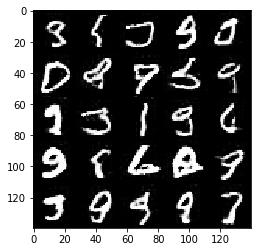

Epoch 1/2 Steps 1850... Discriminator Loss: 1.5274... Generator Loss: 0.5246
Epoch 2/2 Steps 1900... Discriminator Loss: 1.5140... Generator Loss: 0.5002


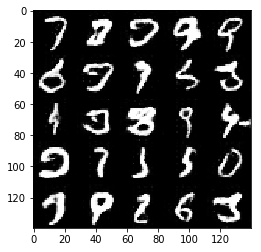

Epoch 2/2 Steps 1950... Discriminator Loss: 1.5280... Generator Loss: 1.0106
Epoch 2/2 Steps 2000... Discriminator Loss: 1.4814... Generator Loss: 0.8138


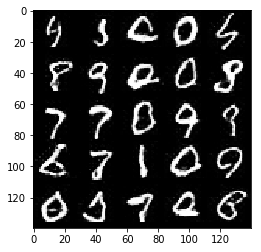

Epoch 2/2 Steps 2050... Discriminator Loss: 1.4362... Generator Loss: 0.6737
Epoch 2/2 Steps 2100... Discriminator Loss: 1.4983... Generator Loss: 0.7355


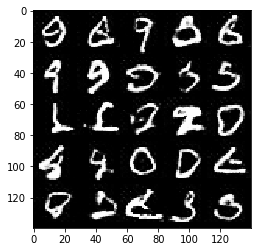

Epoch 2/2 Steps 2150... Discriminator Loss: 1.5945... Generator Loss: 0.4206
Epoch 2/2 Steps 2200... Discriminator Loss: 1.4709... Generator Loss: 0.5347


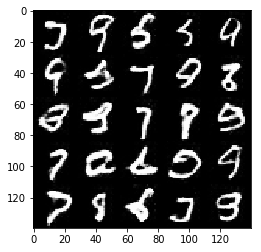

Epoch 2/2 Steps 2250... Discriminator Loss: 1.4619... Generator Loss: 0.6216
Epoch 2/2 Steps 2300... Discriminator Loss: 1.6145... Generator Loss: 0.4580


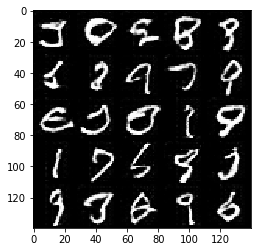

Epoch 2/2 Steps 2350... Discriminator Loss: 1.5087... Generator Loss: 0.5168
Epoch 2/2 Steps 2400... Discriminator Loss: 1.4545... Generator Loss: 0.6097


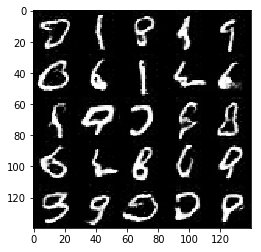

Epoch 2/2 Steps 2450... Discriminator Loss: 1.4611... Generator Loss: 0.5973
Epoch 2/2 Steps 2500... Discriminator Loss: 1.4923... Generator Loss: 0.8361


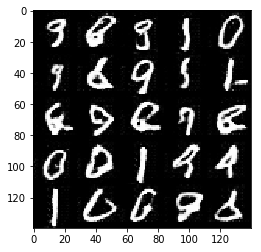

Epoch 2/2 Steps 2550... Discriminator Loss: 1.6154... Generator Loss: 0.4091
Epoch 2/2 Steps 2600... Discriminator Loss: 1.4457... Generator Loss: 0.7877


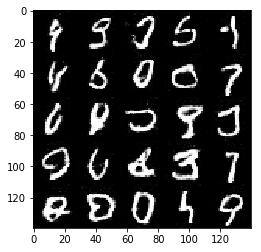

Epoch 2/2 Steps 2650... Discriminator Loss: 1.3904... Generator Loss: 0.8579
Epoch 2/2 Steps 2700... Discriminator Loss: 1.4074... Generator Loss: 0.7897


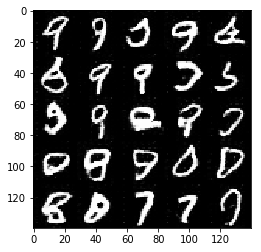

Epoch 2/2 Steps 2750... Discriminator Loss: 1.4659... Generator Loss: 0.5368
Epoch 2/2 Steps 2800... Discriminator Loss: 1.5119... Generator Loss: 0.4792


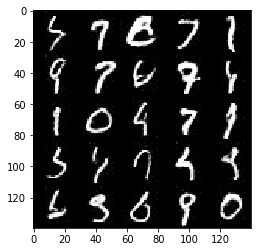

Epoch 2/2 Steps 2850... Discriminator Loss: 1.4317... Generator Loss: 0.8402
Epoch 2/2 Steps 2900... Discriminator Loss: 1.6202... Generator Loss: 0.3878


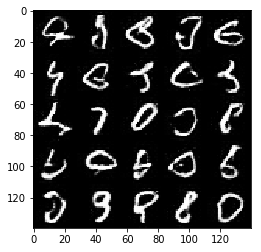

Epoch 2/2 Steps 2950... Discriminator Loss: 1.3782... Generator Loss: 0.6882
Epoch 2/2 Steps 3000... Discriminator Loss: 1.3216... Generator Loss: 0.8051


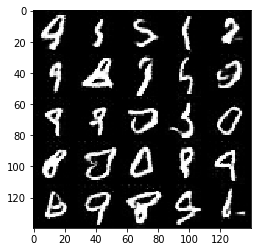

Epoch 2/2 Steps 3050... Discriminator Loss: 1.4710... Generator Loss: 0.5638
Epoch 2/2 Steps 3100... Discriminator Loss: 1.5442... Generator Loss: 0.4662


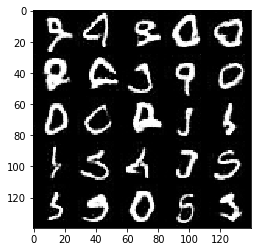

Epoch 2/2 Steps 3150... Discriminator Loss: 1.4169... Generator Loss: 0.5663
Epoch 2/2 Steps 3200... Discriminator Loss: 1.4604... Generator Loss: 0.5888


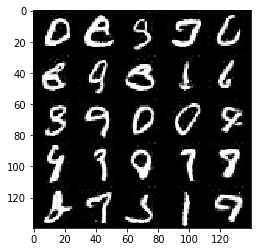

Epoch 2/2 Steps 3250... Discriminator Loss: 1.3805... Generator Loss: 0.7101
Epoch 2/2 Steps 3300... Discriminator Loss: 1.4302... Generator Loss: 0.6672


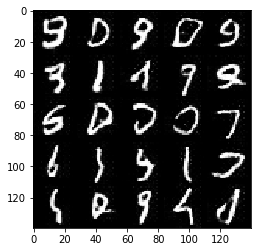

Epoch 2/2 Steps 3350... Discriminator Loss: 1.4270... Generator Loss: 0.7326
Epoch 2/2 Steps 3400... Discriminator Loss: 1.4788... Generator Loss: 0.4931


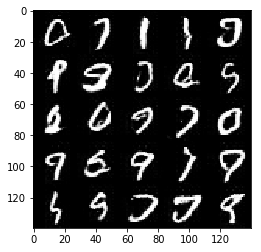

Epoch 2/2 Steps 3450... Discriminator Loss: 1.3843... Generator Loss: 0.7937
Epoch 2/2 Steps 3500... Discriminator Loss: 1.5047... Generator Loss: 0.9499


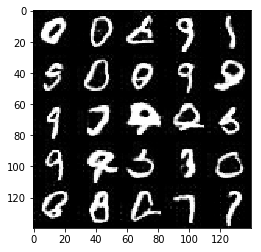

Epoch 2/2 Steps 3550... Discriminator Loss: 1.4271... Generator Loss: 0.7604
Epoch 2/2 Steps 3600... Discriminator Loss: 1.5833... Generator Loss: 0.4006


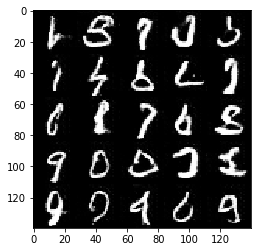

Epoch 2/2 Steps 3650... Discriminator Loss: 1.4734... Generator Loss: 1.1416
Epoch 2/2 Steps 3700... Discriminator Loss: 1.4436... Generator Loss: 0.5310


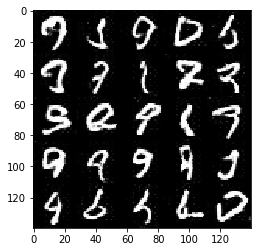

Epoch 2/2 Steps 3750... Discriminator Loss: 1.4555... Generator Loss: 0.7382


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.003
beta1 = 0.4
#tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Steps 50... Discriminator Loss: 4.0670... Generator Loss: 0.0354
Epoch 1/1 Steps 100... Discriminator Loss: 2.8422... Generator Loss: 0.1088


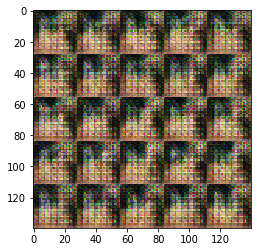

Epoch 1/1 Steps 150... Discriminator Loss: 1.9428... Generator Loss: 0.5091
Epoch 1/1 Steps 200... Discriminator Loss: 1.9907... Generator Loss: 0.3307


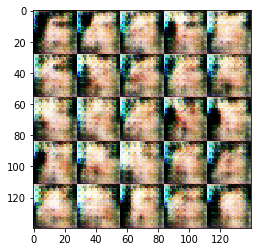

Epoch 1/1 Steps 250... Discriminator Loss: 1.8260... Generator Loss: 0.4353
Epoch 1/1 Steps 300... Discriminator Loss: 1.9079... Generator Loss: 0.2956


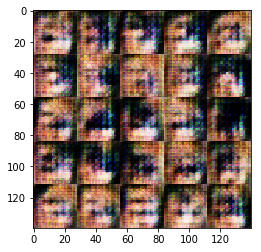

Epoch 1/1 Steps 350... Discriminator Loss: 1.7213... Generator Loss: 0.4334
Epoch 1/1 Steps 400... Discriminator Loss: 1.6767... Generator Loss: 0.4432


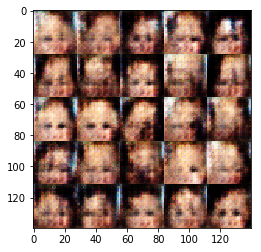

Epoch 1/1 Steps 450... Discriminator Loss: 1.8192... Generator Loss: 0.3804
Epoch 1/1 Steps 500... Discriminator Loss: 1.7612... Generator Loss: 0.5437


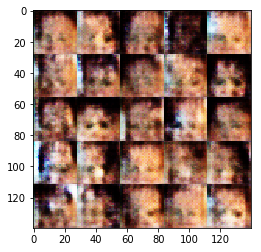

Epoch 1/1 Steps 550... Discriminator Loss: 1.8115... Generator Loss: 0.4451
Epoch 1/1 Steps 600... Discriminator Loss: 1.7248... Generator Loss: 0.5256


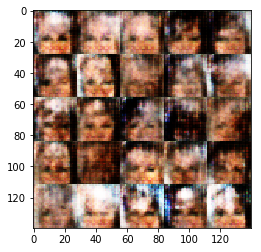

Epoch 1/1 Steps 650... Discriminator Loss: 1.6830... Generator Loss: 0.5161
Epoch 1/1 Steps 700... Discriminator Loss: 1.8671... Generator Loss: 0.3435


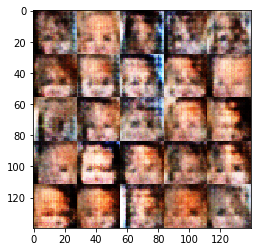

Epoch 1/1 Steps 750... Discriminator Loss: 1.7325... Generator Loss: 0.4322
Epoch 1/1 Steps 800... Discriminator Loss: 1.7169... Generator Loss: 0.5819


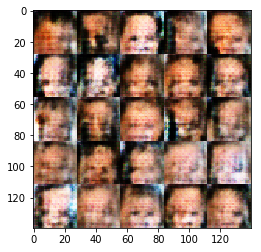

Epoch 1/1 Steps 850... Discriminator Loss: 1.6749... Generator Loss: 0.6466
Epoch 1/1 Steps 900... Discriminator Loss: 1.7284... Generator Loss: 0.4432


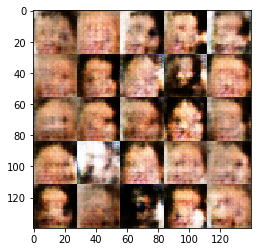

Epoch 1/1 Steps 950... Discriminator Loss: 1.7391... Generator Loss: 0.5193
Epoch 1/1 Steps 1000... Discriminator Loss: 1.7455... Generator Loss: 0.4612


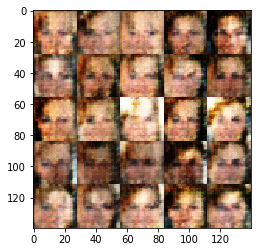

Epoch 1/1 Steps 1050... Discriminator Loss: 1.6215... Generator Loss: 0.5541
Epoch 1/1 Steps 1100... Discriminator Loss: 1.5548... Generator Loss: 0.7117


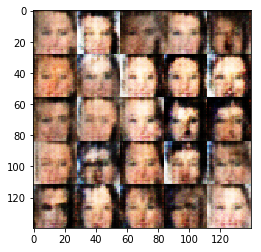

Epoch 1/1 Steps 1150... Discriminator Loss: 1.7204... Generator Loss: 0.4765
Epoch 1/1 Steps 1200... Discriminator Loss: 1.6890... Generator Loss: 0.4555


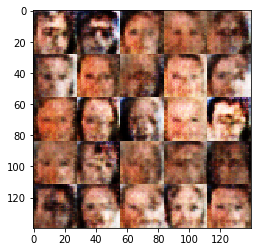

Epoch 1/1 Steps 1250... Discriminator Loss: 1.6741... Generator Loss: 0.5025
Epoch 1/1 Steps 1300... Discriminator Loss: 1.7164... Generator Loss: 0.5806


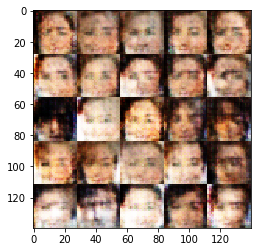

Epoch 1/1 Steps 1350... Discriminator Loss: 1.6905... Generator Loss: 0.4680
Epoch 1/1 Steps 1400... Discriminator Loss: 1.6517... Generator Loss: 0.5871


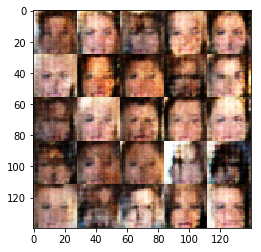

Epoch 1/1 Steps 1450... Discriminator Loss: 1.7925... Generator Loss: 0.5306
Epoch 1/1 Steps 1500... Discriminator Loss: 1.7259... Generator Loss: 0.5634


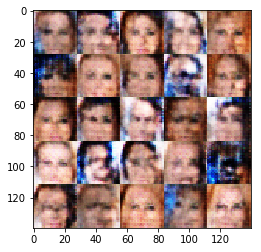

Epoch 1/1 Steps 1550... Discriminator Loss: 1.6001... Generator Loss: 0.5298
Epoch 1/1 Steps 1600... Discriminator Loss: 1.5826... Generator Loss: 0.5804


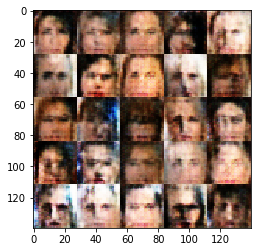

Epoch 1/1 Steps 1650... Discriminator Loss: 1.6639... Generator Loss: 0.5984
Epoch 1/1 Steps 1700... Discriminator Loss: 1.5590... Generator Loss: 0.6152


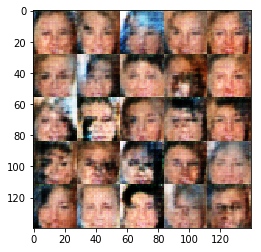

Epoch 1/1 Steps 1750... Discriminator Loss: 1.5771... Generator Loss: 0.5782
Epoch 1/1 Steps 1800... Discriminator Loss: 1.6763... Generator Loss: 0.5970


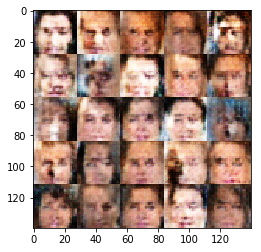

Epoch 1/1 Steps 1850... Discriminator Loss: 1.6021... Generator Loss: 0.6101
Epoch 1/1 Steps 1900... Discriminator Loss: 1.7304... Generator Loss: 0.5171


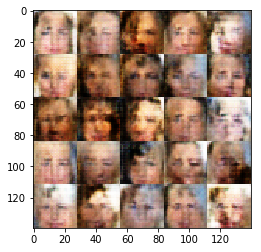

Epoch 1/1 Steps 1950... Discriminator Loss: 1.7422... Generator Loss: 0.4662
Epoch 1/1 Steps 2000... Discriminator Loss: 1.6568... Generator Loss: 0.5519


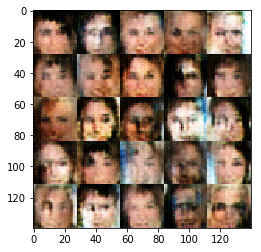

Epoch 1/1 Steps 2050... Discriminator Loss: 1.6419... Generator Loss: 0.5506
Epoch 1/1 Steps 2100... Discriminator Loss: 1.7777... Generator Loss: 0.4848


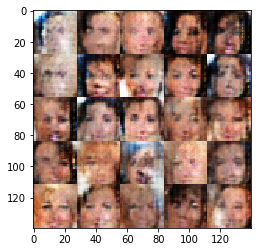

Epoch 1/1 Steps 2150... Discriminator Loss: 1.6213... Generator Loss: 0.4997
Epoch 1/1 Steps 2200... Discriminator Loss: 1.6975... Generator Loss: 0.4947


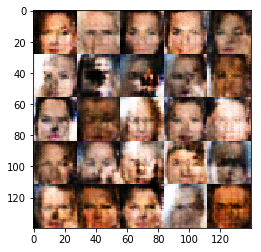

Epoch 1/1 Steps 2250... Discriminator Loss: 1.6783... Generator Loss: 0.5192
Epoch 1/1 Steps 2300... Discriminator Loss: 1.6634... Generator Loss: 0.4953


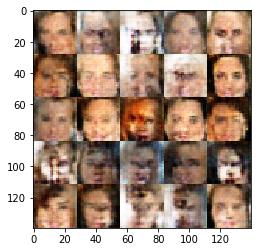

Epoch 1/1 Steps 2350... Discriminator Loss: 1.6299... Generator Loss: 0.5216
Epoch 1/1 Steps 2400... Discriminator Loss: 1.6317... Generator Loss: 0.5681


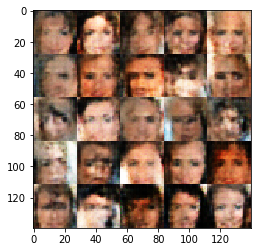

Epoch 1/1 Steps 2450... Discriminator Loss: 1.6822... Generator Loss: 0.4670
Epoch 1/1 Steps 2500... Discriminator Loss: 1.7638... Generator Loss: 0.4409


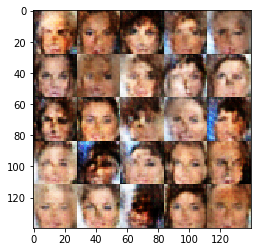

Epoch 1/1 Steps 2550... Discriminator Loss: 1.6346... Generator Loss: 0.5677
Epoch 1/1 Steps 2600... Discriminator Loss: 1.6396... Generator Loss: 0.5448


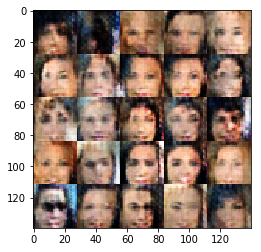

Epoch 1/1 Steps 2650... Discriminator Loss: 1.7006... Generator Loss: 0.4302
Epoch 1/1 Steps 2700... Discriminator Loss: 1.6919... Generator Loss: 0.4837


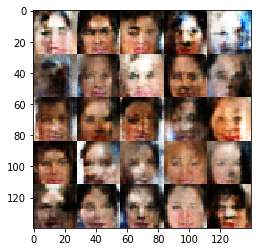

Epoch 1/1 Steps 2750... Discriminator Loss: 1.6388... Generator Loss: 0.4960
Epoch 1/1 Steps 2800... Discriminator Loss: 1.6234... Generator Loss: 0.5601


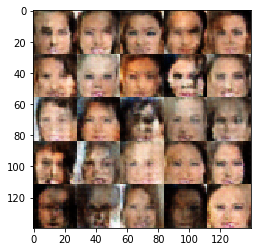

Epoch 1/1 Steps 2850... Discriminator Loss: 1.7426... Generator Loss: 0.4175
Epoch 1/1 Steps 2900... Discriminator Loss: 1.6506... Generator Loss: 0.4988


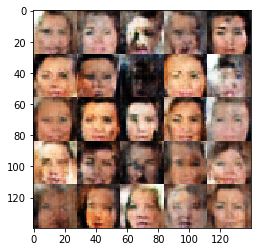

Epoch 1/1 Steps 2950... Discriminator Loss: 1.6015... Generator Loss: 0.6092
Epoch 1/1 Steps 3000... Discriminator Loss: 1.6655... Generator Loss: 0.5190


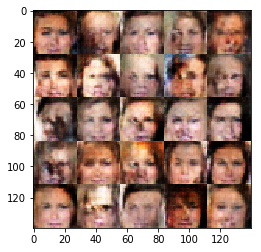

Epoch 1/1 Steps 3050... Discriminator Loss: 1.7097... Generator Loss: 0.5064
Epoch 1/1 Steps 3100... Discriminator Loss: 1.6767... Generator Loss: 0.4925


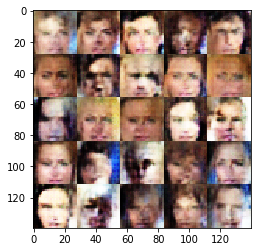

Epoch 1/1 Steps 3150... Discriminator Loss: 1.6200... Generator Loss: 0.5546
Epoch 1/1 Steps 3200... Discriminator Loss: 1.6545... Generator Loss: 0.5551


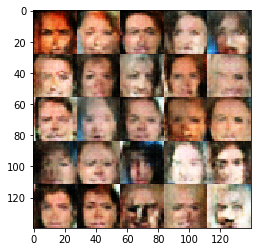

Epoch 1/1 Steps 3250... Discriminator Loss: 1.6539... Generator Loss: 0.5364
Epoch 1/1 Steps 3300... Discriminator Loss: 1.7410... Generator Loss: 0.4672


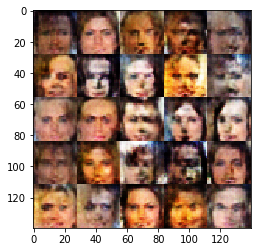

Epoch 1/1 Steps 3350... Discriminator Loss: 1.7129... Generator Loss: 0.5010
Epoch 1/1 Steps 3400... Discriminator Loss: 1.7230... Generator Loss: 0.4911


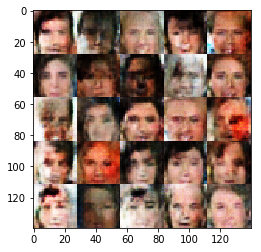

Epoch 1/1 Steps 3450... Discriminator Loss: 1.6559... Generator Loss: 0.4942
Epoch 1/1 Steps 3500... Discriminator Loss: 1.6922... Generator Loss: 0.5170


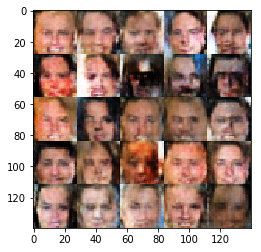

Epoch 1/1 Steps 3550... Discriminator Loss: 1.6660... Generator Loss: 0.5546
Epoch 1/1 Steps 3600... Discriminator Loss: 1.7111... Generator Loss: 0.4609


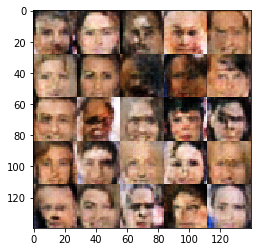

Epoch 1/1 Steps 3650... Discriminator Loss: 1.7335... Generator Loss: 0.4929
Epoch 1/1 Steps 3700... Discriminator Loss: 1.6536... Generator Loss: 0.5728


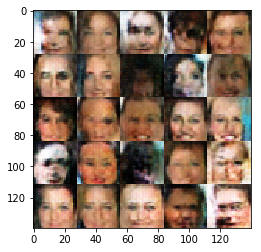

Epoch 1/1 Steps 3750... Discriminator Loss: 1.6910... Generator Loss: 0.5084
Epoch 1/1 Steps 3800... Discriminator Loss: 1.6761... Generator Loss: 0.5273


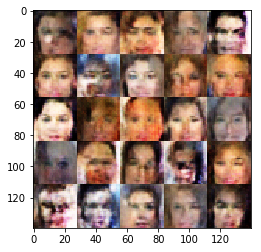

Epoch 1/1 Steps 3850... Discriminator Loss: 1.7268... Generator Loss: 0.5257
Epoch 1/1 Steps 3900... Discriminator Loss: 1.5956... Generator Loss: 0.6074


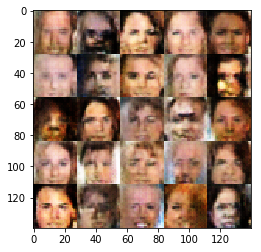

Epoch 1/1 Steps 3950... Discriminator Loss: 1.6788... Generator Loss: 0.4998
Epoch 1/1 Steps 4000... Discriminator Loss: 1.6331... Generator Loss: 0.5293


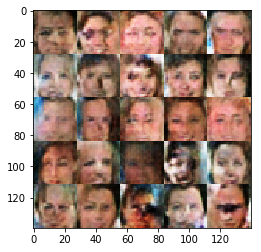

Epoch 1/1 Steps 4050... Discriminator Loss: 1.6327... Generator Loss: 0.6043
Epoch 1/1 Steps 4100... Discriminator Loss: 1.6547... Generator Loss: 0.5326


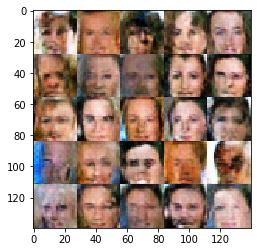

Epoch 1/1 Steps 4150... Discriminator Loss: 1.6256... Generator Loss: 0.5221
Epoch 1/1 Steps 4200... Discriminator Loss: 1.6511... Generator Loss: 0.5386


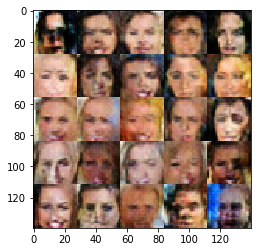

Epoch 1/1 Steps 4250... Discriminator Loss: 1.6085... Generator Loss: 0.5422
Epoch 1/1 Steps 4300... Discriminator Loss: 1.6705... Generator Loss: 0.5301


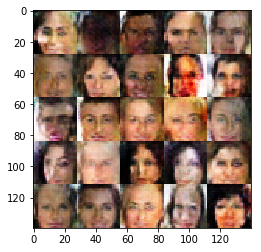

Epoch 1/1 Steps 4350... Discriminator Loss: 1.6776... Generator Loss: 0.5147
Epoch 1/1 Steps 4400... Discriminator Loss: 1.6520... Generator Loss: 0.5059


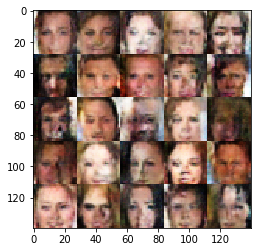

Epoch 1/1 Steps 4450... Discriminator Loss: 1.6100... Generator Loss: 0.5953
Epoch 1/1 Steps 4500... Discriminator Loss: 1.6092... Generator Loss: 0.5600


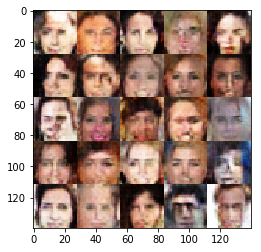

Epoch 1/1 Steps 4550... Discriminator Loss: 1.6470... Generator Loss: 0.5341
Epoch 1/1 Steps 4600... Discriminator Loss: 1.6366... Generator Loss: 0.5205


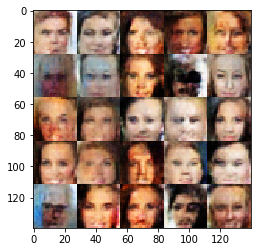

Epoch 1/1 Steps 4650... Discriminator Loss: 1.6021... Generator Loss: 0.5259
Epoch 1/1 Steps 4700... Discriminator Loss: 1.6559... Generator Loss: 0.5087


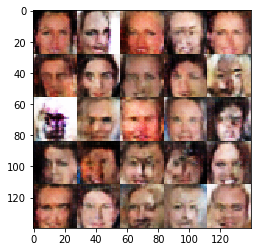

Epoch 1/1 Steps 4750... Discriminator Loss: 1.6158... Generator Loss: 0.5401
Epoch 1/1 Steps 4800... Discriminator Loss: 1.5643... Generator Loss: 0.5780


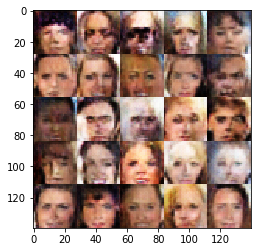

Epoch 1/1 Steps 4850... Discriminator Loss: 1.6831... Generator Loss: 0.4941
Epoch 1/1 Steps 4900... Discriminator Loss: 1.5809... Generator Loss: 0.5785


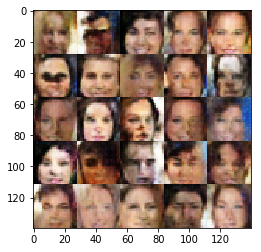

Epoch 1/1 Steps 4950... Discriminator Loss: 1.6420... Generator Loss: 0.5118
Epoch 1/1 Steps 5000... Discriminator Loss: 1.6330... Generator Loss: 0.5153


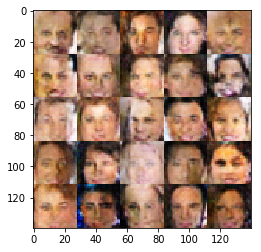

Epoch 1/1 Steps 5050... Discriminator Loss: 1.6048... Generator Loss: 0.5843
Epoch 1/1 Steps 5100... Discriminator Loss: 1.5972... Generator Loss: 0.5403


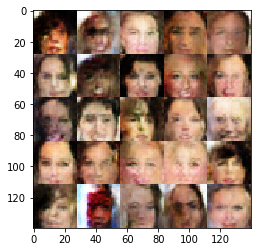

Epoch 1/1 Steps 5150... Discriminator Loss: 1.5790... Generator Loss: 0.5407
Epoch 1/1 Steps 5200... Discriminator Loss: 1.5941... Generator Loss: 0.5583


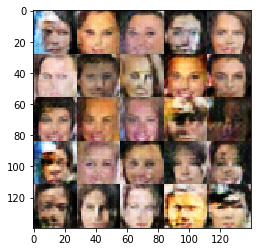

Epoch 1/1 Steps 5250... Discriminator Loss: 1.6062... Generator Loss: 0.5608
Epoch 1/1 Steps 5300... Discriminator Loss: 1.5639... Generator Loss: 0.6302


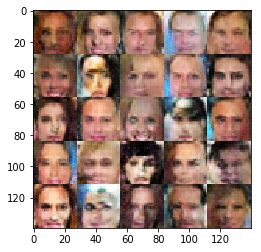

Epoch 1/1 Steps 5350... Discriminator Loss: 1.6161... Generator Loss: 0.5395
Epoch 1/1 Steps 5400... Discriminator Loss: 1.6089... Generator Loss: 0.5761


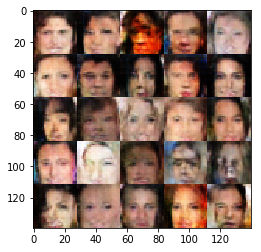

Epoch 1/1 Steps 5450... Discriminator Loss: 1.6110... Generator Loss: 0.5382
Epoch 1/1 Steps 5500... Discriminator Loss: 1.5357... Generator Loss: 0.5858


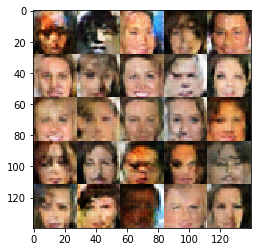

Epoch 1/1 Steps 5550... Discriminator Loss: 1.6352... Generator Loss: 0.5553
Epoch 1/1 Steps 5600... Discriminator Loss: 1.5797... Generator Loss: 0.5474


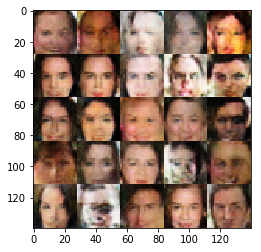

Epoch 1/1 Steps 5650... Discriminator Loss: 1.5881... Generator Loss: 0.5214
Epoch 1/1 Steps 5700... Discriminator Loss: 1.5988... Generator Loss: 0.5678


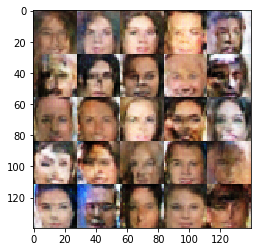

Epoch 1/1 Steps 5750... Discriminator Loss: 1.6112... Generator Loss: 0.5612
Epoch 1/1 Steps 5800... Discriminator Loss: 1.6216... Generator Loss: 0.5094


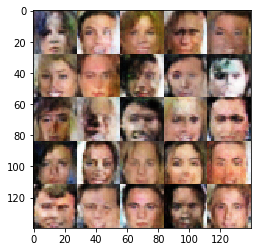

Epoch 1/1 Steps 5850... Discriminator Loss: 1.5748... Generator Loss: 0.5716
Epoch 1/1 Steps 5900... Discriminator Loss: 1.6060... Generator Loss: 0.5429


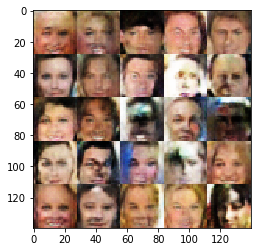

Epoch 1/1 Steps 5950... Discriminator Loss: 1.6046... Generator Loss: 0.5432
Epoch 1/1 Steps 6000... Discriminator Loss: 1.5636... Generator Loss: 0.5599


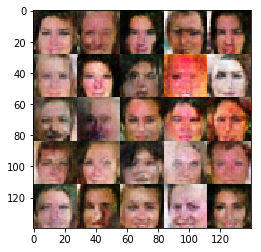

Epoch 1/1 Steps 6050... Discriminator Loss: 1.6292... Generator Loss: 0.5521
Epoch 1/1 Steps 6100... Discriminator Loss: 1.6334... Generator Loss: 0.5441


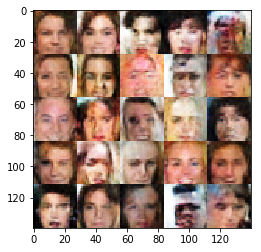

Epoch 1/1 Steps 6150... Discriminator Loss: 1.5732... Generator Loss: 0.5929
Epoch 1/1 Steps 6200... Discriminator Loss: 1.5880... Generator Loss: 0.5929


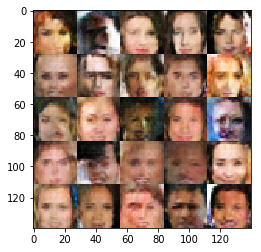

Epoch 1/1 Steps 6250... Discriminator Loss: 1.5575... Generator Loss: 0.5822
Epoch 1/1 Steps 6300... Discriminator Loss: 1.6483... Generator Loss: 0.5275


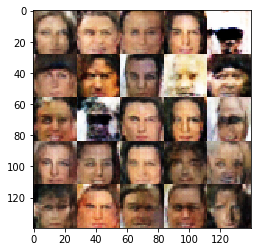

In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3
#tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.